In [10]:
import wandb
wandb.login()

wandb: Currently logged in as: vmazeeva (vmazeeva-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


True

In [1]:
import os
os.environ["WANDB_SILENT"] = "true"

In [ ]:
! python resnet.py -data_dir '../chest_xray' -n_epochs 1 -img_size 512

python(96531) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/opt/anaconda3/envs/ml_ai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ml_ai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training on device: mps

Epoch 1
----------------------
Train:   5%|▌         | 4/74 [00:34<08:00,  6.86s/it, acc=71.8750%, loss=0.6512]^C


wandb-core(33789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(33800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(33801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(33802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(33803) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(33812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(33834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(33835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(33836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(33837) MallocStackLogging: can't turn off malloc stack logging because 

In [ ]:
! python vit.py -data_dir {new_dataset} -n_epochs 1 -batch_size 16

In [34]:
! python gradcam.py -model_path '../models/SimpleCNN_lr0.0001_img512_b16_finetune.pth' -model_type SimpleCNN -img_path '../chest_xray/test/NORMAL/IM-0049-0001.jpeg' -img_class 0

/Users/veramazeeva/Library/CloudStorage/OneDrive-Personal/Carnegie Mellon/CompMed/project/code/gradcam.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state

In [35]:
! python gradcam.py -model_path '../models/SimpleCNN_lr0.0001_img512_b16_finetune.pth' -model_type SimpleCNN -img_path '../chest_xray/test/PNEUMONIA/person21_bacteria_73.jpeg' -img_class 1

/Users/veramazeeva/Library/CloudStorage/OneDrive-Personal/Carnegie Mellon/CompMed/project/code/gradcam.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state

In [48]:
DEVICE = "cpu"

In [49]:
import numpy as np
import torch
from tqdm import tqdm

def evaluate(model, dataloader, dataname, criterion, confusion_matrix=False):
    batch_size = dataloader.batch_size

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc=f'Evaluate on {dataname} dataset')

    total_loss, num_correct = 0, 0

    TP, TN, FP, FN = 0, 0, 0, 0

    with torch.no_grad():
        for idx, (images, labels) in enumerate(dataloader):

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, dim=1)

            num_correct += int((preds==labels).sum())
            total_loss += float(loss.item())

            for p, l in zip(preds, labels):
                if p == 1 and l == 1:
                    TP += 1
                elif p == 0 and l == 0:
                    TN += 1
                elif p == 1 and l == 0:
                    FP += 1
                elif p == 0 and l == 1:
                    FN += 1

            batch_bar.set_postfix(
                acc= "{:.04f}%".format(num_correct/(batch_size*(idx+1))*100),
                loss= "{:.04f}".format(float(total_loss/(idx+1)))
            )

            batch_bar.update()

    batch_bar.close()

    acc = num_correct/(batch_size*(idx+1))*100
    avg_loss = total_loss/(idx+1)

    sensitivity, specificity =  TP / (TP + FN), TN / (TN + FP)

    if not confusion_matrix:
        return avg_loss, acc, sensitivity, specificity
    
    else:
        cm = np.array([[TP, FP], [FN, TN]])
        return avg_loss, acc, sensitivity, specificity, cm

In [58]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets


transforms_common = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),  
])
transforms_train = [transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.Resize((512,512)),
                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
                transforms.ToTensor()]

transforms_train.append(transforms.Normalize(mean=[0.5519], std=[0.2131]))

class_to_label = {"NORMAL": 0, "PNEUMONIA": 1}
assert(len(class_to_label) == 2)
dataset = datasets.ImageFolder('../chest_xray/test', transform=transforms.Compose(transforms_train))
dataset.class_to_idx = class_to_label


dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [40]:
from cnn import SimpleCNN
from torch import nn

In [59]:
model = SimpleCNN()
model.load_state_dict(torch.load('../models/SimpleCNN_lr0.0001_img512_b16_finetune.pth', map_location='cpu'))
criterion = nn.CrossEntropyLoss()

evaluate(model, dataloader, 'train', criterion)

/var/folders/gb/6nj_ltrj4xz37dn5k89d40n00000gn/T/ipykernel_33002/957929743.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/Si

(0.1428833143099358, 91.11842105263158, 0.9425837320574163, 0.9580838323353293)

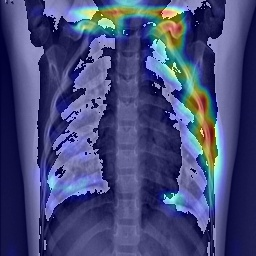

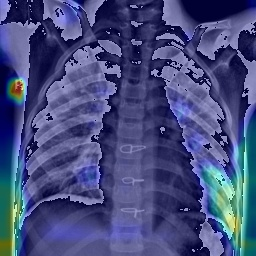

(None, None)

In [36]:
from IPython.display import Image, display
display(Image("gradcam/gradcam_0.jpg")), display(Image("gradcam/gradcam_1.jpg"))

In [2]:
from cnn import SimpleCNN 
import torch
import torchvision.transforms as T
import numpy as np
import cv2
from PIL import Image

In [7]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

from resnet import MyResNET

model = SimpleCNN()
model.load_state_dict(torch.load('../models/SimpleCNN_lr3e-05_img512_b16.pth', map_location='mps'))
target_layers = [model.conv_stack[-3]]

image_transforms = T.Compose([T.RandomHorizontalFlip(),
                T.RandomRotation(15),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                T.Resize((512,512)),
                T.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
                T.ToTensor()])



rgb_img = cv2.imread('../chest_xray/test/PNEUMONIA/person9_bacteria_40.jpeg', 1)[:, :, ::-1]
rgb_img = np.float32(rgb_img) / 255
image = Image.open('../chest_xray/test/PNEUMONIA/person9_bacteria_40.jpeg').convert("L")  # Ensure grayscale
input_tensor = image_transforms(image).unsqueeze(0)  # Add batch dimension



# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(0)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

/var/folders/gb/6nj_ltrj4xz37dn5k89d40n00000gn/T/ipykernel_33002/722778332.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/Si

In [8]:
torch.nn.functional.softmax(model_outputs) 

/var/folders/gb/6nj_ltrj4xz37dn5k89d40n00000gn/T/ipykernel_33002/2432447706.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(model_outputs) # normal


tensor([[2.5014e-09, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

In [25]:
model = MyResNET()
model.load_state_dict(torch.load('../models/ResNET_lr3e-05_img256_b32.pth', map_location='mps'))

image_transforms = T.Compose([T.RandomHorizontalFlip(),
                T.RandomRotation(15),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                T.Resize((256,256)),
                T.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
                T.ToTensor()])

#image = Image.open('../chest_xray/test/PNEUMONIA/person9_bacteria_40.jpeg').convert("L")  # Ensure grayscale
image = Image.open('../chest_xray/test/NORMAL/IM-0049-0001.jpeg').convert("L")  # Ensure grayscale

input_tensor = image_transforms(image).unsqueeze(0)  # Add batch dimension

model.eval()
output = model(input_tensor)
output

/var/folders/gb/6nj_ltrj4xz37dn5k89d40n00000gn/T/ipykernel_33002/1833528600.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/R

tensor([[ 5.0175, -5.1121]], grad_fn=<AddmmBackward0>)